# COGS 118A FINAL PROJECT

## Data setup

> First let's download some libraries we will be using throughout this notebook.

In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install wfdb
!pip install statsmodels
!pip install scipy
!pip install imbalanced-learn
!pip install TensorFlow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb

> We will be using the PTB-XL dataset. Past development of automated systems to detect irregularities in ECG have been hindered due to the lack of set methods of evaluation of developed models, and a lack of large, publically available datasets as well for the use of developing ML models. Thus, PTB-XL was a big leap forward in developing this field. Let's see what the dataset looks like!

In [3]:
ptb_xl = pd.read_csv('ptbxl_database.csv')

ptb_xl

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21833,21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21834,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
21835,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr


> There are a lot of columns, and this seems confusing at first glance. Here are all of the columns we can use:

In [4]:
ptb_xl.columns

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

> The main columns that we are interested in is ecg_id, scp_codes, and filename_lr. The ecg_id provides a way to identify each waveform, which are stored in separate directories; scp_codes provides a standard way of providing a diagnosis to each waveform and its associated ecg id in a nice and programmatic way that we can use, and filename_lr provides the file name of the waveform for each associated ecg id entry in each row, the lr standing for "low resolution" signals that were recorded at 100Hz from 12 different electrodes, and two referece electrodes on the left and right arms. Speaking of these waveforms, let's see what they look like!

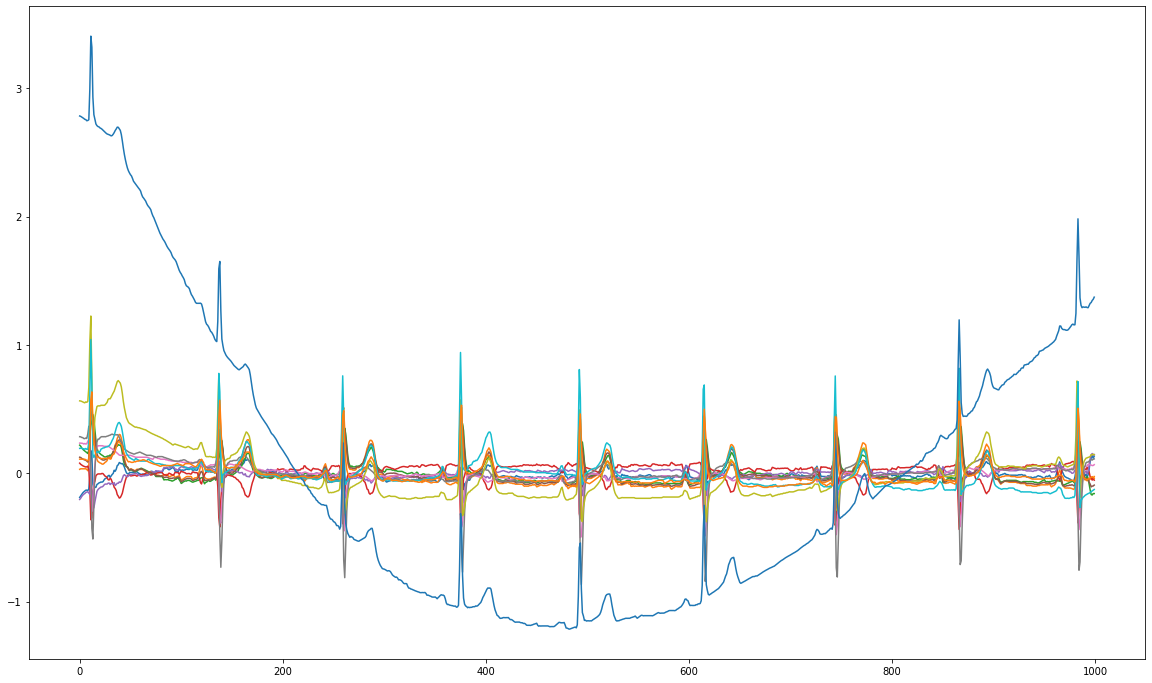

In [5]:
ecg_ids, waveform_file_names = ptb_xl['ecg_id'].values,ptb_xl['filename_lr'].values 
ecg_id_waveform_pairings = dict(zip(ecg_ids,waveform_file_names))

rand_idx = np.random.randint(len(ecg_id_waveform_pairings.keys()))
example_waveform = wfdb.rdsamp(ecg_id_waveform_pairings[rand_idx])[0].T


'''
wfdb is a python library for reading waveform data and is used by much of the medical field for other
forms of bioelectric data

For this dataset, each time we call rdsamp, we are returned a tuple of the actual multi-channel waveform data, and related
meta-data, which is why we take the 0th index. We then transpose it for greater ease of plotting, so that now each index is
stored row-wise in a python friendly fashion, rather than column wise, which would require more index slicing to access
channel data. 
''';

plt.figure(figsize=(20,12))
[plt.plot(channel) for channel in example_waveform];

> So now know how to access the raw waveform data, but what about the actual diagnostic classes? First, we have to look at the possible super diagnostic classes and the sub classes that fall under each one. For this we can use the scp_statements csv file that gives us a general guide on how to parse the diagnostics from the PTBXL data.

In [6]:
scp_statements = pd.read_csv('scp_statements.csv')
scp_statements = scp_statements[scp_statements['diagnostic']==1]
scp_statements

,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
0,NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
1,NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
2,DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
3,LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
4,NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7
5,IMI,inferior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferior myocardial infarction,161.0,NaN,NaN,NaN
6,ASMI,anteroseptal myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anteroseptal myocardial infarction,165.0,NaN,NaN,NaN
7,LVH,left ventricular hypertrophy,1.0,NaN,NaN,HYP,LVH,Ventricular Hypertrophy,left ventricular hypertrophy,142.0,NaN,C71076,NaN
8,LAFB,left anterior fascicular block,1.0,NaN,NaN,CD,LAFB/LPFB,Intraventricular and intra-atrial Conduction d...,left anterior fascicular block,101.0,MDC_ECG_BEAT_BLK_ANT_L_HEMI,C62267,D3-33140
9,ISC_,non-specific ischemic,1.0,NaN,NaN,STTC,ISC_,Basic roots for coding ST-T changes and abnorm...,ischemic ST-T changes,226.0,NaN,NaN,NaN


> There were some diagnostics with no value, denoted by a NaN value under the diagnostic column, so we first filtered the SCP statements to only include existing diagnostics. We can see that each diagnostic class has its own set of diagnostic subclasses that fall into it. We do not wish to classify all of the possible diagnostic subclasses, but only the general diagnostic classes, so to extract this information from the PTBXL data, we will first build a dictionary that pairs each diagnostic subclass with its super class.

In [7]:
sub_classes = scp_statements['Unnamed: 0'].values
super_classes = scp_statements['diagnostic_class'].values

class_pairings = dict(zip(sub_classes,super_classes))
class_pairings

{'NDT': 'STTC',
 'NST_': 'STTC',
 'DIG': 'STTC',
 'LNGQT': 'STTC',
 'NORM': 'NORM',
 'IMI': 'MI',
 'ASMI': 'MI',
 'LVH': 'HYP',
 'LAFB': 'CD',
 'ISC_': 'STTC',
 'IRBBB': 'CD',
 '1AVB': 'CD',
 'IVCD': 'CD',
 'ISCAL': 'STTC',
 'CRBBB': 'CD',
 'CLBBB': 'CD',
 'ILMI': 'MI',
 'LAO/LAE': 'HYP',
 'AMI': 'MI',
 'ALMI': 'MI',
 'ISCIN': 'STTC',
 'INJAS': 'MI',
 'LMI': 'MI',
 'ISCIL': 'STTC',
 'LPFB': 'CD',
 'ISCAS': 'STTC',
 'INJAL': 'MI',
 'ISCLA': 'STTC',
 'RVH': 'HYP',
 'ANEUR': 'STTC',
 'RAO/RAE': 'HYP',
 'EL': 'STTC',
 'WPW': 'CD',
 'ILBBB': 'CD',
 'IPLMI': 'MI',
 'ISCAN': 'STTC',
 'IPMI': 'MI',
 'SEHYP': 'HYP',
 'INJIN': 'MI',
 'INJLA': 'MI',
 'PMI': 'MI',
 '3AVB': 'CD',
 'INJIL': 'MI',
 '2AVB': 'CD'}

> Let's also see how many different classes of diagnoses we will be classifying

In [8]:
np.unique(super_classes)

array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object)

> Now, why did we bother with building this dictionary? Because the SCP code in the PTB XL data is in terms of the diagnostic sub class, so now we can pair each one with one of the five super classes. 

In [9]:
import ast

In [10]:
scp_codes = ptb_xl['scp_codes']
scp_codes

0                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
1                             {'NORM': 80.0, 'SBRAD': 0.0}
2                               {'NORM': 100.0, 'SR': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21832    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21833             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21834                           {'ISCAS': 50.0, 'SR': 0.0}
21835                           {'NORM': 100.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21837, dtype: object

> Since each dictionary is stored as a string in the data, we use the ast library to convert it into a defaul python type, and extract the sub class diagnosis for each entry. 

In [11]:
sub_diagnosis = scp_codes.apply(lambda x: list(ast.literal_eval(x).keys())[0]).values
ptb_xl = ptb_xl.assign(sub_diagnoses = sub_diagnosis) 

> However, we do have an issue that some of the classes mentioned in the PTB XL data is not in our list of sub classes from the scp statements data. Let's see which ones, and filter them out. 

In [12]:
not_included_diagnoses = set(np.unique(sub_diagnosis)).difference(set(np.unique(sub_classes)))
ptb_xl = ptb_xl[~ptb_xl.sub_diagnoses.isin(not_included_diagnoses)]

sub_diagnosis = ptb_xl.scp_codes.apply(lambda x: list(ast.literal_eval(x).keys())[0]).values
#Re-running this line now that we have dropped the not included diagnoses

not_included_diagnoses

{'AFIB', 'AFLT', 'PACE', 'PSVT', 'PVC', 'STACH'}

In [13]:
general_diagnoses = [class_pairings[diagnosis] for diagnosis in sub_diagnosis]
ptb_xl = ptb_xl.assign(general_diagnoses = general_diagnoses)
ptb_xl

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,sub_diagnoses,general_diagnoses
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,NORM,NORM
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,NORM,NORM
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,NORM,NORM
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,NORM,NORM
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,NORM,NORM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,NDT,STTC
21833,21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,NORM,NORM
21834,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,ISCAS,STTC
21835,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,NORM,NORM


> And now we have everything we need. We would like to build a dataset ow where we have the general diagnostic, and the associated 12-channel waveform representing the associated ECG. This cell takes a littl bit to run since it is reading the valaues of 21,000 12-channel ECG readings!

In [14]:
waveform_file_names = ptb_xl.filename_lr.values
diagnoses = ptb_xl.general_diagnoses.values

waveforms = [wfdb.rdsamp(file_name)[0].T for file_name in waveform_file_names]

In [15]:
waveforms = np.array(waveforms)
waveforms.shape

(21411, 12, 1000)

> So we now have 21411 12x100 entries for out dataset. Each entry is a 12x1000 matrix, representing a 12 channel recording of a 10 second ECG (We know this is ten seconds because of the 100Hz sampling rate). Let's also see our class distribution.

In [16]:
ptb_xl.groupby('general_diagnoses').size()

general_diagnoses
CD      2324
HYP     1310
MI      5439
NORM    9528
STTC    2810
dtype: int64

> We definitely have some misbalancing issues, with the 'NORM' representing a majority of the entries, so we will have to deal with this in the subsequent sections, but aside from that let's go over what these abbreviations mean. 

STTC: An abnormality in the ST segment of the heart
CD: Conductive defect of electrical impulses through the heart
HYP: This one is a bit unclear... as many of the diagnoses notes were written in German.
MI: Myocardial Infarction (Irregular beating of heart following a heart attack)

## Data Exploration and Feature Engineering

> First, let's see if we are dealing with stationary signals or not, as that will drastically affect the types of time series modeling we can perform on the data. For this we will perform an ADF test on each channel on a small sample of the data points. 

In [17]:
from statsmodels.tsa.stattools import adfuller

#For our multi channel time series
def perform_adf_test(time_series):
    n_channels = 12
    return np.mean([adfuller(channel,autolag='AIC')[1] for channel in time_series]) 
    #Returning the mean p-value across channels
                
#Choosing 100 random samples to perform adf test on
sample_size = 100
rand_indices = np.random.choice(range(len(waveforms)),sample_size)

rand_waveforms = waveforms[rand_indices]
mean_p_val = np.mean([perform_adf_test(waveform) for waveform in rand_waveforms])

mean_p_val

0.03152712161288268

> This suggests that our signals across channels are stationary, which allows us to use something like auto-regression to model them. A lot of modeling of time series also depends understanding how previous values of the time series affect the next values. We can look into this relationship using PACF plots. 

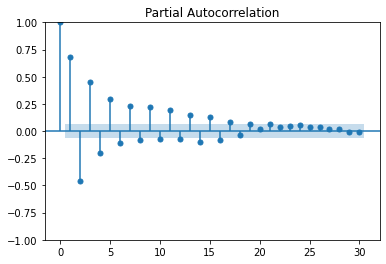

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf

mean_waveforms = np.mean(waveforms,axis=1)
rand_idx = np.random.randint(len(mean_waveforms))

plot_pacf(mean_waveforms[rand_idx],method='ywm');

> In the previous cell we averaged our data across channels. Let's also perform some signal analysis on our data and create some visualizations. 

c:\users\20gun\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


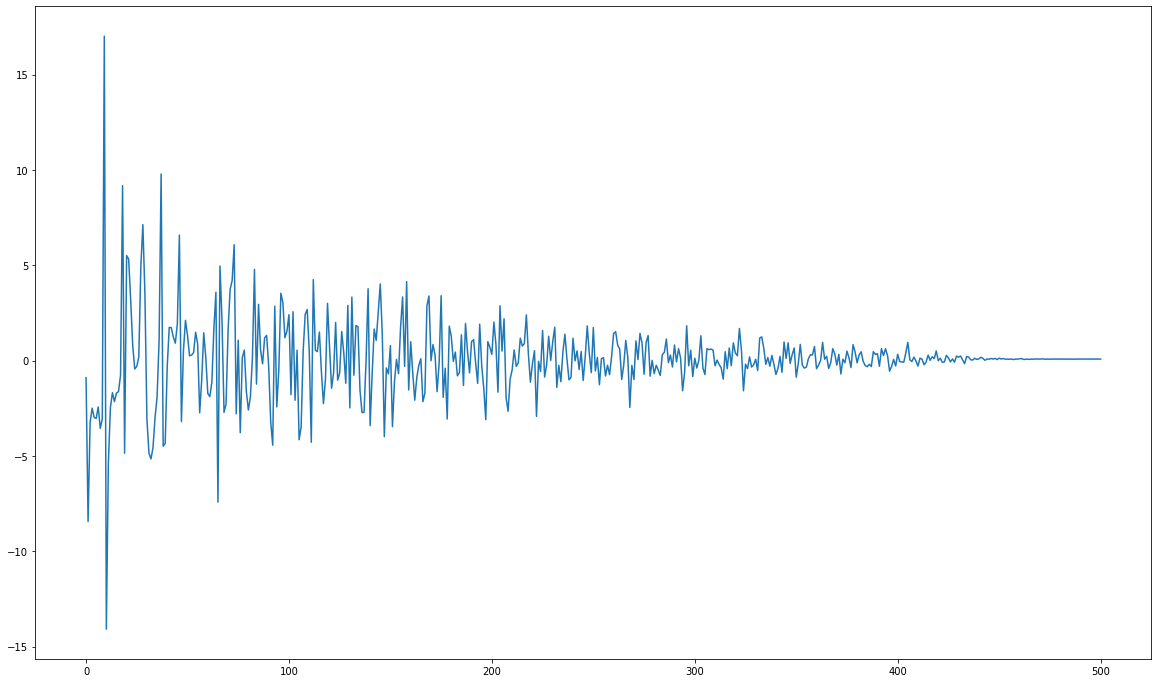

In [19]:
rand_idx = np.random.randint(len(mean_waveforms))

plt.figure(figsize=(20,12))
fft = np.fft.rfft(mean_waveforms[rand_idx])

plt.plot(fft)

> The spikes in the data make analysis in the frequency domain rather complicated, and we do not really have enough knowledge of Fourier Analysis to know how to deal with it... perhaps the PSD plots will be cleaner!

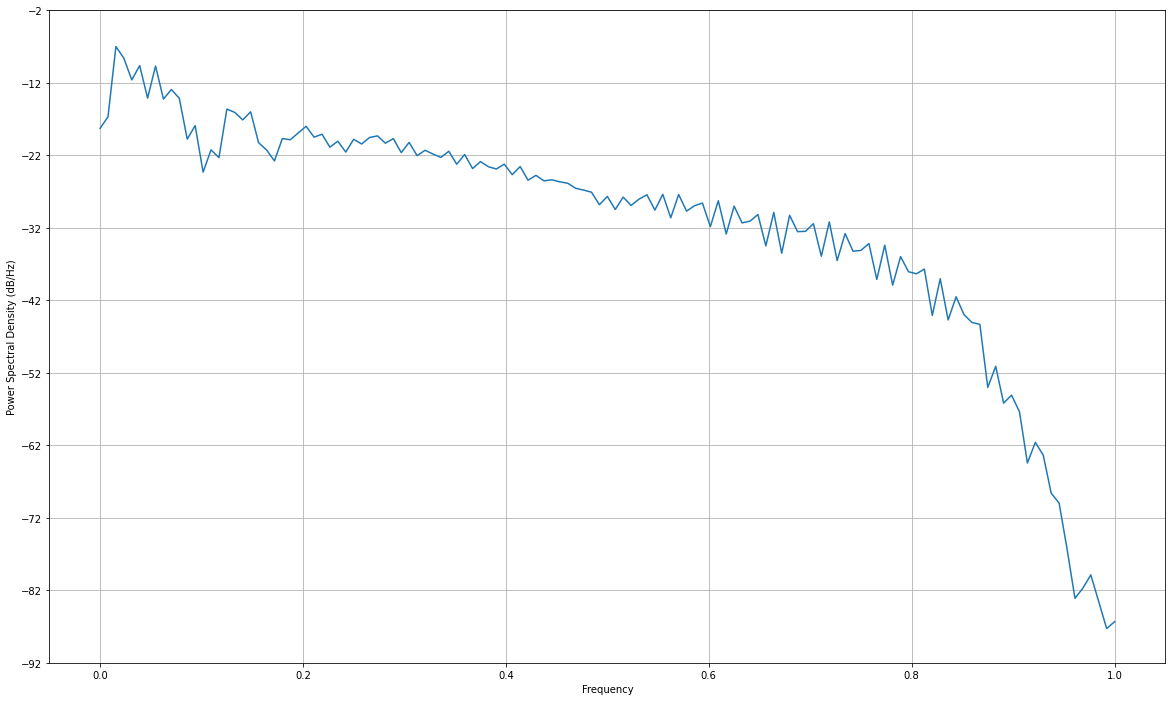

In [20]:
plt.figure(figsize=(20,12))
plt.psd(mean_waveforms[rand_idx]);

> However, it is not very helpful to see only individual samples. We have our average waveforms, so now let's split them up based on their label, and then visualize the one-dimensional FFT and PSDs on two different plots (one for each respective transform), and then average the transformed signals across labels as well so that we can get just one concrete image on how these different classes of signals may differ from eachother. 

In [21]:
class_names = np.unique(diagnoses)
class_labels = list(range(0,5))

class_dict = {key:value for (key,value) in zip(class_names,class_labels)}
organized_by_class = [[] for _ in class_names]

for i in range(len(mean_waveforms)):
    class_label = class_dict[diagnoses[i]]
    organized_by_class[class_label].append(mean_waveforms[i])
    
mean_class_waveforms = [np.mean(class_waveform,axis=0) for class_waveform in organized_by_class]

> Let's first see how the classes vary across the raw signals, frequency domain, and the PSD plots

In [22]:
def plot_transform(data,transform):
    plt.figure(figsize=(20,12))
    for class_waveform in mean_class_waveforms:
        plt.plot(transform(class_waveform),alpha=0.6)
        plt.legend(class_names,loc='upper left')

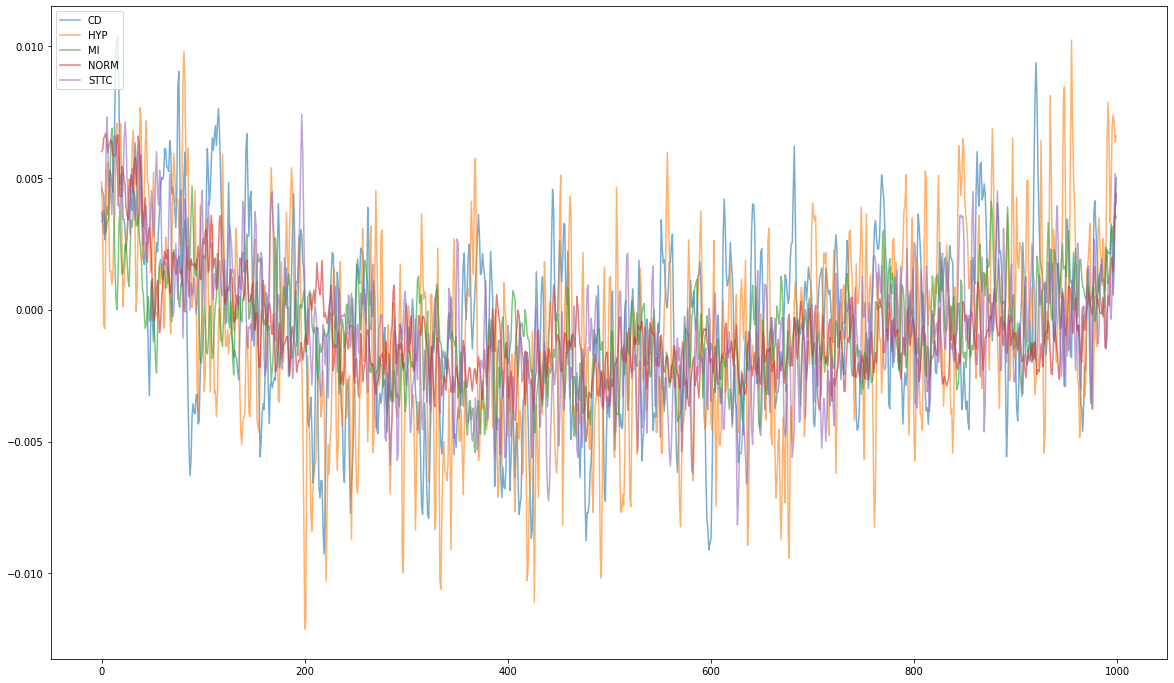

In [23]:
plt.figure(figsize=(20,12))
for class_waveform in mean_class_waveforms:
    plt.plot(class_waveform,alpha=0.6)
    plt.legend(class_names,loc='upper left')

c:\users\20gun\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\20gun\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\20gun\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\20gun\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\20gun\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: Compl

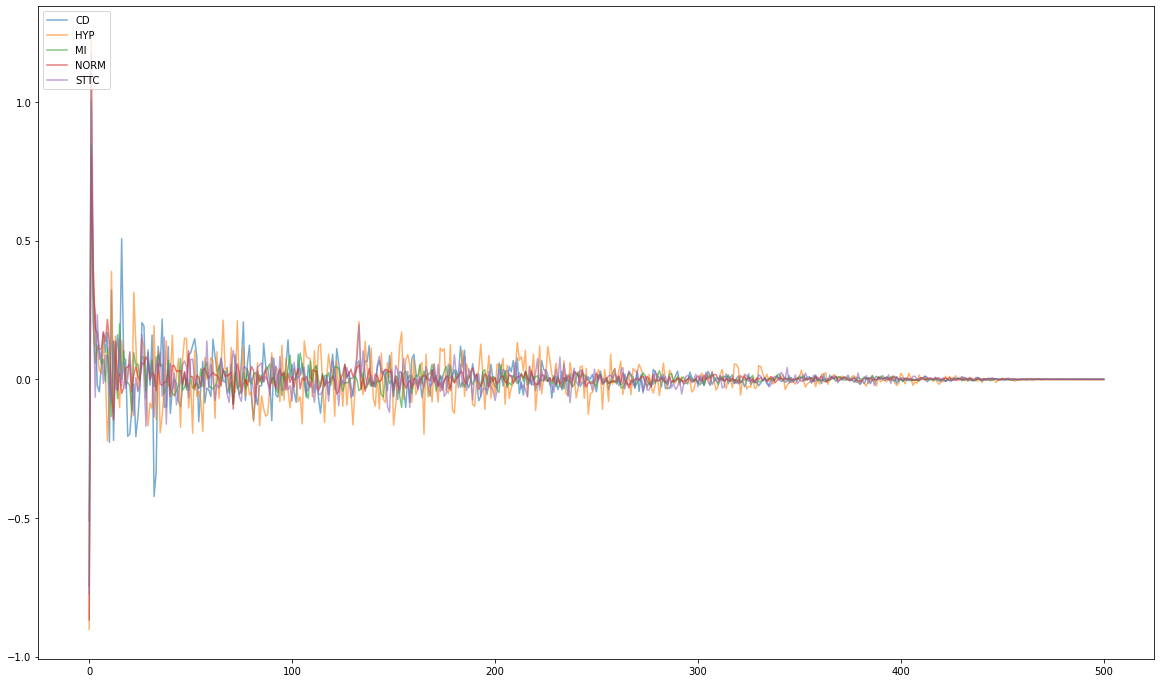

In [24]:
plot_transform(mean_class_waveforms,np.fft.rfft)

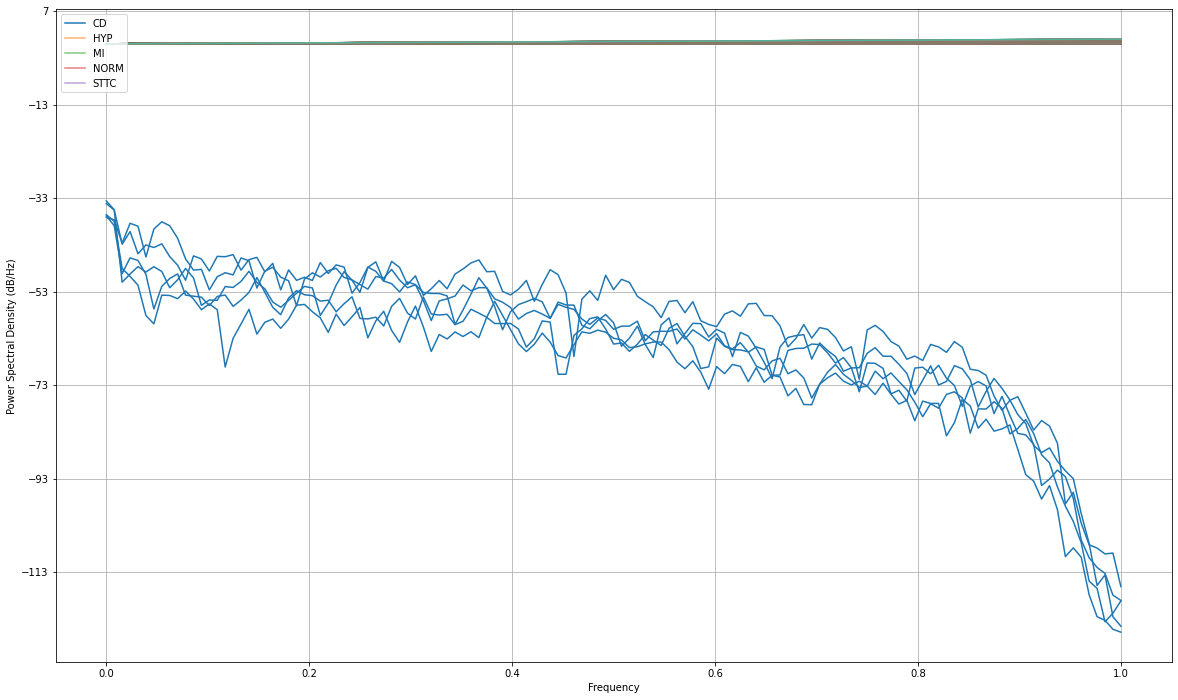

In [25]:
plot_transform(mean_class_waveforms,plt.psd)

## Model Selection and Training 

> So, the feature engineering that we will try in our models involves FFT, PSD, and Auto Regressive parameters of time series. We have around 21,000 data poins, and we want to try to have more than 100x data points compared to number of features, so we will try to keep our number of features less than 210, which is also part of the reason we chose to use the 100Hz down sampled data instead of the 500Hz one. 

> We first implement a bandpass filter on our signals. We use a 0.05Hz high-pass filter to get rid of low-frequency varations across signals, and do not implement a low-pass filter as it does not seem appropriate in this context, as it might directly interfere with the high frequency heart beat. 

In [26]:
from scipy.signal import periodogram,lfilter,butter
from statsmodels.tsa.ar_model import AutoReg

In [27]:
order = 5
cutoff = 0.05
fs = 100


b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
filtered_ecg = lfilter(b, a, waveforms)

> Let's first perform all of our needed transforms

In [28]:
waveforms_fft = np.real(np.fft.rfft(filtered_ecg))

In [29]:
waveforms_fft.shape

(21411, 12, 501)

In [30]:
waveforms_psd = periodogram(filtered_ecg)[1]

In [31]:
waveforms_fft = np.reshape(waveforms_fft,[len(waveforms_fft),12*501])

In [32]:
waveforms_psd = np.reshape(waveforms_psd,[len(waveforms_psd),12*501])

> We have five total classes, and a pretty complex data distribution for each of our features, so instead of just using a basic logistic regression classifier, we use the One v.s One framework to perform multi-classification.

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [34]:
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(waveforms_fft, diagnoses, test_size=0.2)

> In order to limit parameters in our model as much as possible, let's also limit the number of dimensions of our data points, and let's say we would like to explain 90% of the variance in our data. 

In [35]:
pca_fft = PCA(n_components=0.9)
X_train_fft = pca_fft.fit_transform(X_train_fft)
X_train_fft.shape

(17128, 7)

> So we were able to account for 90% of the variance in our FFT data with just 7 components out of the original 6012! This helps us drastically. Now let's finally run some experiments with grid search and our different features!

In [36]:
X_test_fft = PCA(n_components=7).fit_transform(X_test_fft)

X_train_fft = StandardScaler().fit_transform(X_train_fft)
X_test_fft = StandardScaler().fit_transform(X_test_fft)

In [37]:
model = OneVsOneClassifier(LogisticRegression())

param_grid = {
            'estimator__solver':['liblinear'],
            'estimator__penalty' : ['l1', 'l2'],
            'estimator__C' : [1,10,100,1000],
            }

clf = GridSearchCV(model, param_grid = param_grid, cv = 5, verbose=True);

In [38]:
clf.fit(X_train_fft,y_train_fft);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [39]:
pd.DataFrame(clf.cv_results_)[['mean_test_score','param_estimator__C','param_estimator__penalty']]

,mean_test_score,param_estimator__C,param_estimator__penalty
0,0.448564,1,l1
1,0.448564,1,l2
2,0.448564,10,l1
3,0.448564,10,l2
4,0.448564,100,l1
5,0.448564,100,l2
6,0.448564,1000,l1
7,0.448564,1000,l2


> Now let's see how our model does on the PSD data. (We ran the cell defining our model again before doing so).

In [40]:
waveforms_psd = PCA(n_components=0.9).fit_transform(waveforms_psd)

In [41]:
waveforms_psd.shape

(21411, 2)

In [42]:
X_train_psd, X_test_psd, y_train_psd, y_test_psd = train_test_split(waveforms_psd, diagnoses, test_size=0.2)

In [43]:
X_train_psd = StandardScaler().fit_transform(X_train_psd)

X_test_psd = PCA(n_components=2).fit_transform(X_test_psd)
X_test_psd = StandardScaler().fit_transform(X_test_psd)

In [44]:
clf.fit(X_train_psd,y_train_psd)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=OneVsOneClassifier(estimator=LogisticRegression()),
             param_grid={'estimator__C': [1, 10, 100, 1000],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             verbose=True)

In [45]:
pd.DataFrame(clf.cv_results_)[['mean_test_score','param_estimator__C','param_estimator__penalty']]

,mean_test_score,param_estimator__C,param_estimator__penalty
0,0.443426,1,l1
1,0.443426,1,l2
2,0.443601,10,l1
3,0.443543,10,l2
4,0.443601,100,l1
5,0.443601,100,l2
6,0.443601,1000,l1
7,0.443601,1000,l2


> Now let's see how we do using AR coefficients.

In [46]:
get_ar_params = lambda x: np.reshape(([AutoReg(waveform,lags=10).fit().params for waveform in x]),[12*11,])

In [47]:
waveforms_ar_params = np.array(list(map(get_ar_params,waveforms)))

> Since here we have a manageable amount of parameters, we will not use PCA, nor will we use any standardization since the statsmodels library already has a standardization process when calculating AR model coefficients. We run the cell again defining our grid search classifier before continuing. 

In [48]:
X_train_ar, X_test_ar, y_train_ar, y_test_ar = train_test_split(waveforms_ar_params, diagnoses, test_size=0.2)

In [ ]:
clf.fit(X_train_ar,y_train_ar);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [82]:
pd.DataFrame(clf.cv_results_)[['mean_test_score','param_estimator__C','param_estimator__penalty']]

,mean_test_score,param_estimator__C,param_estimator__penalty
0,0.443134,1,l1
1,0.443134,1,l2
2,0.443017,10,l1
3,0.443017,10,l2
4,0.443017,100,l1
5,0.443017,100,l2
6,0.443017,1000,l1
7,0.443017,1000,l2


> We get pretty similar results across the board, but it is important to understand why our classifier combined with our feature engineering idea is not performing optimally. 

## Error Analysis and Conclusions

> First let's get an exact idea of where our classifiers are making errors. Is the error distributed uniformly across classes or is it just one or two classes out of the five that is mostly contributing?

In [60]:
from sklearn.metrics import confusion_matrix

In [54]:
optimal_model_fft = OneVsOneClassifier(LogisticRegression(penalty='l1',solver='liblinear')) #C = 1 by default
optimal_model_psd = OneVsOneClassifier(LogisticRegression(penalty='l1',solver='liblinear'))
optimal_model_ar = OneVsOneClassifier(LogisticRegression(penalty='l1',solver='liblinear'))

In [55]:
optimal_model_fft.fit(X_train_fft,y_train_fft)

OneVsOneClassifier(estimator=LogisticRegression(penalty='l1',
                                                solver='liblinear'))

In [56]:
optimal_model_psd.fit(X_train_psd,y_train_psd)

OneVsOneClassifier(estimator=LogisticRegression(penalty='l1',
                                                solver='liblinear'))

In [57]:
optimal_model_ar.fit(X_train_ar,y_train_ar)

OneVsOneClassifier(estimator=LogisticRegression(penalty='l1',
                                                solver='liblinear'))

In [59]:
y_pred_fft = optimal_model_fft.predict(X_test_fft)
y_pred_psd = optimal_model_psd.predict(X_test_psd)
y_pred_ar = optimal_model_ar.predict(X_test_ar)

(<matplotlib.image.AxesImage at 0x16f2ae3c1c8>,
 array([[   0,    0,    0,  458,    0],
        [   0,    0,    0,  272,    0],
        [   0,    0,    0, 1115,    0],
        [   1,    0,    0, 1844,    0],
        [   0,    1,    0,  592,    0]], dtype=int64))

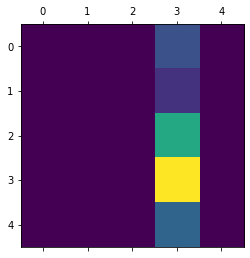

In [71]:
plt.matshow(confusion_matrix(y_test_fft,y_pred_fft)),confusion_matrix(y_test_fft,y_pred_fft)

(<matplotlib.image.AxesImage at 0x16f29fa1648>,
 array([[   4,    1,    5,  420,    1],
        [   2,    1,    4,  239,    1],
        [   5,    4,   23, 1112,    0],
        [  17,    3,   34, 1872,    1],
        [   3,    5,    6,  520,    0]], dtype=int64))

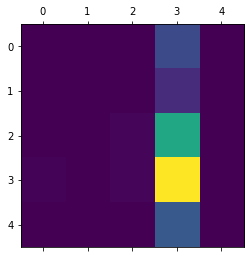

In [72]:
plt.matshow(confusion_matrix(y_test_psd,y_pred_psd)),confusion_matrix(y_test_psd,y_pred_psd)

(<matplotlib.image.AxesImage at 0x16f2acf1288>,
 array([[  97,    0,  192,  135,   21],
        [   6,    5,   83,  170,   20],
        [  59,    6,  606,  323,   62],
        [  10,    2,  208, 1658,   62],
        [  12,    4,  122,  308,  112]], dtype=int64))

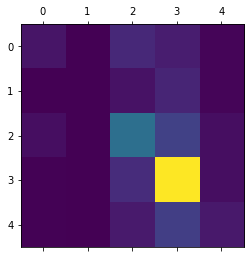

In [73]:
plt.matshow(confusion_matrix(y_test_ar,y_pred_ar)),confusion_matrix(y_test_ar,y_pred_ar)

> The confusion matrices reveal a pretty interesting story... for some reason across most of our featur engineering methods, the model seems to be predicting the normal class most of the time! This effect is most profound in the FFT data, and less so in the auto-regressive parameter data, but even then it is quite strong.This is most likely due to the fact that we do have misbalanced data where 'NORM' (class 3) is the most common class. Even when we tried to address this with SMOTE, we ran into similar results.This suggests that our feature engineering is not doing a good enough job of representing the true class distributions in the training data. 

> Why does this seem to be the case, even though the normal class is the most represented in our data? Especially when working with noisy signals generated from biological processes like that of a heart beat, it seems that traditional signal and very bare-bones signal processing methods do not seem to be enough, and that more specialized techniques that taken into account the physical processess occuring must be used. Sometimes it is too naive to look at things from a purely mathematics point of view, and not think a bit deeper about the physical systems that the math is trying to represent. 